<a href="https://colab.research.google.com/github/ioahKwon/storm-analysis-zcalib/blob/main/Final_dao3d_zcal_ipynb_202105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ◈ **This ipynb file was made by IOAH, SNU GSCST.** ◈

Version 1.0.0 (2021. 05. 06.)

### Z Calibration Curves for 3D-DAOSTORM (and sCMOS).

In this example we are trying to determine the coefficients $w_o,c,d,A,B,C,D$ in this equation:

\begin{equation*}
W_{x,y} = w_o \sqrt{1 + \left(\frac{z-c}{d}\right)^2 + A\left(\frac{z-c}{d}\right)^3 + B\left(\frac{z-c}{d}\right)^4 + C\left(\frac{z-c}{d}\right)^5 + D\left(\frac{z-c}{d}\right)^6}
\end{equation*}

This is a modified form of a typical microscope defocusing curve. $W_x$, $W_y$ are the widths of the localization as measured by 3D-DAOSTORM and $z$ is the localization $z$ offset in $um$.

See also [Huang et al, Science, 2008](http://dx.doi.org/10.1126/science.1153529).


## **1) Calibration : Configuration**


### ① Setting 1 : Getting Data and Storm Analysis from google drive & github.

In [1]:
# FIXME: This approach is very brittle. There would seem to be several
#        solutions, none of which I was able to figure out how to actually
#        implement.
#
#        1. Query for the name and directory of the installed .egg file.
#        2. Don't install project, just add it's location to Python's
#           module search path.
#
import sys

# Test to see if we need to install storm-analysis or if we already did this.
try:
  import storm_analysis
  
except ModuleNotFoundError:

  # Install SCONS and FFTW3 C library.
  !apt install scons
  !apt install libfftw3-dev

  # Get latest version of storm-analysis.
  # original : !git clone https://github.com/ZhuangLab/storm-analysis.git

  # GIT Hub : https://github.com/ioahKwon/
  # !git clone https://github.com/ioahKwon/storm-analysis-IOAH.git # IOAH Version (2021.05.12.)
  !git clone https://github.com/KimLab-SNU/storm-analysis-kimlab.git # IOAH Version (last updated: 2021. 05. 12.)

  # Change to directory and compile.
  %cd storm-analysis-kimlab
  !scons

  # Install storm-analysis project.
  !{sys.executable} setup.py install
  
  # Manually add the installed storm-analysis project to the path.
  sys.path.append('/usr/local/lib/python3.6/dist-packages/storm_analysis-2.1-py3.6.egg')

  # Install dependencies.
  !{sys.executable} -m pip install tifffile

  # Return to parent directory.
  %cd ..

# These are for diagnostics.
!pwd
!ls

/content
sample_data  storm-analysis-kimlab


In [2]:
# Warn user to restart kernel in order for storm-analysis to load properly. 
# The problem is that running Python might not be able to find the installed 
# library if isn't where we expected it to be.
#
try:
  import storm_analysis
  
except ModuleNotFoundError:
  print("Storm-analysis not found!")
  print("Restart Python kernel before continuing!")
  
else:
  for elt in sys.path:
    if "storm" in elt:
      print(elt)

/usr/local/lib/python3.7/dist-packages/storm_analysis-2.2-py3.7.egg


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Data path
data_path = "/content/gdrive/My Drive/data/20210326"

# Load sample z_offsets.txt file. In this example every frame is valid.
import numpy
import os
import tifffile as tiff

# Z offsets profile
######z_offsets = numpy.loadtxt("z_offsets.txt")
address_z_offsets = os.path.join(data_path, "z_offsets.txt")
print("Location of z_offsets : ", address_z_offsets)
z_offsets = numpy.loadtxt(address_z_offsets)
######print(z_offsets)

# Bead Locations
address_bead_locs = os.path.join(data_path, "bead_locs.txt")
print("Location of bead_locs : ", address_bead_locs)

bead_locs = numpy.loadtxt(address_bead_locs)
print(bead_locs)


# Tiff file
print("\n")
tif_file = os.path.join(data_path,"obSTORM_3DPSF_RedBead175nmDia_f200Cyl_z1_m1p8um_30nm_1p8um_1_combined.tif" )
print("tif_file : ",tif_file)
image = tiff.imread(tif_file)
print(image)

Location of z_offsets :  /content/gdrive/My Drive/data/20210326/z_offsets.txt
Location of bead_locs :  /content/gdrive/My Drive/data/20210326/bead_locs.txt
[[ 23.  24.]
 [ 68.  24.]
 [113.  24.]
 [158.  24.]]


tif_file :  /content/gdrive/My Drive/data/20210326/obSTORM_3DPSF_RedBead175nmDia_f200Cyl_z1_m1p8um_30nm_1p8um_1_combined.tif
[[[4367 4429 4336 ... 4464 4421 4399]
  [4360 4332 4314 ... 4330 4379 4481]
  [4307 4378 4313 ... 4364 4406 4370]
  ...
  [4247 4313 4285 ... 5148 5281 5463]
  [4360 4302 4283 ... 5597 5083 5410]
  [4237 4231 4233 ... 5614 5315 5148]]

 [[4307 4445 4365 ... 4512 4596 4596]
  [4372 4283 4342 ... 4355 4391 4398]
  [4370 4323 4265 ... 4393 4399 4348]
  ...
  [4194 4256 4333 ... 5228 5281 5023]
  [4301 4286 4264 ... 5403 5545 5414]
  [4299 4464 4237 ... 5241 5300 5194]]

 [[4344 4498 4237 ... 4403 4628 4448]
  [4263 4242 4364 ... 4442 4382 4458]
  [4423 4399 4204 ... 4457 4426 4463]
  ...
  [4303 4309 4291 ... 5386 5344 5376]
  [4228 4297 4311 ... 5436 5470 53

### ② Setting 2 : Parameter Settings.

Set parameters for 3D-DAOSTORM analysis. Note the analysis is done using the `3d` PSF model, a Gaussian with independent widths in X/Y.

In [5]:
import storm_analysis.sa_library.parameters as params

# Load the parameters
params = params.ParametersDAO()

# Analysis parameters

###########################
###  Essential Parameter ##
###########################
pixel_size = 144.5                                                # CCD pixel size (in nm)
max_z = 0.1
min_z = -1.2
z_step = 0.01
###########################


params.changeAttr("pixel_size", pixel_size)                       # CCD pixel size (in nm)
params.changeAttr("max_frame", -1)                                # The frame to stop analysis on, -1 = analyze to the end of the film.
params.changeAttr("start_frame", -1)                              # The frame to start analysis on, -1 = start at the beginning of the film
params.changeAttr("max_z", max_z)                                   # Maximum z value for z fitting, specified in um. ( z_range )
params.changeAttr("min_z", min_z)                                  # Minimum z value for z fitting, specified in um. ( z_range )
params.changeAttr('verbosity', 1)                                 # Frequency in frames at which to provide feedback. The default is every frame (verbosity = 1). This should be an integer >= 1.
params.changeAttr('static_background_estimate', 0)                # If this is set, and set to a number greater than 0, then the analysis will estimate the background by using the average over this number of frames.
                                                                    # If this is not set, or set to 0, the background is estimated separately for each frame.
# Tracking parameters
params.changeAttr("descriptor", 1)                                # Tracking parameter, frame descriptor string :
                                                                    # 0 - activation frame
                                                                    # 1 - non-specific frame
                                                                    # 2 - channel1 frame
                                                                    # 3 - channel2 frame
                                                                    # 4 - etc..

params.changeAttr("radius", 0.5)                                  # Radius for matching peaks from frame to frame. Localizations that are closer than
                                                                    # this value (in pixels) in adjacent frames (ignoring activation frames) are assumed
                                                                    # to come from the same emitter and are averaged together to create a (hopefully) 
                                                                    # more accurately localized emitter. If this is zero then no matching will be done
                                                                    # if it is 0, don't do tracking.
                                                                  # Maximum distance for an object to be in a track in pixels. 

# Drift Correction parameters
params.changeAttr("d_scale", 2)                                   # if your data is 256x256 pixels then the drift-correction will create 512x512 sub-STORM 
                                                                    # images (for d_scale = 2) and then attempt to correlate these images to each other to calculate the drift.
                                                                    # 2 is usually a good choice.
params.changeAttr("drift_correction", 0)                          # Do drift correction, 0 ='No'
params.changeAttr("z_correction", 0)                              # Do z drift correction, 0 = 'No'
params.changeAttr("frame_step", 100)                              # Number of frames in each (drift correction) sub-STORM image # 500


# Fitting parameters

sigma = 1.5

params.changeAttr("background_sigma", 8.0)                        # Background filter sigma, this is the sigma of a 2D gaussian to convolve the data in order to estimate the background.

params.changeAttr("fftw_estimate", 0)                             # FFTW should estimate the best FFT plan instead of measuring which is best. This 
                                                                    # can help speed the analysis of short movies that are very large in XY. 0 = (default) 
                                                                    # FFTW will measure the best FFT plan. 1 = FFTW will estimate the best FFT plan.

params.changeAttr("fit_error_model", "MLE")                       # Specify which fitting error model to use. # Other Options : ALS(Anscombe Least Squares), LS(Least Squares), DWLS(Data Weighted Least Squares), FWLS(Fit Weighted Least Squares)
params.changeAttr("find_max_radius", 6,  node_type='int')         # To be a peak it must be the maximum value within this radius (in pixels).
                                                                    # Using a large find max radius -> reduces peak splitting.
params.changeAttr("iterations", 20)                               # Maximum number of iterations for new peak finding.
params.changeAttr("sigma", sigma)                                  # This is the estimated sigma of the PSF in pixels.
                                                                    # It is used in most of the analysis approaches as a measure of the peak to peak distance at which peak fits do not substantially effect each other.
                                                                    # In most of the analysis approaches, if two peaks are closer than
                                                                    #	this distance then the dimmer one will be discarded.
params.changeAttr('sigma_range', [0.5*sigma, 5.0*sigma])         # A two element array that specifies the minimum and maximum sigma values to allow when fitting for the peak width. 
                                                                    # If this is not specified the default is [0.5 * sigma, 5.0 * sigma].


params.changeAttr("threshold", 6 )                                # Threshold for a maximum to considered a peak.
                                                                    # This is the threshold for peak finding in units of signal to background. A
                                                                    # value of 3 for example corresponds to only selecting peaks with an (estimated)
                                                                    # signal to background ratio of 3.
                                                                    # You probably want a value of at least 5.

# Parameters that are common to 3D-DAOSTORM and sCMOS
params.changeAttr("cutoff", 2)                                    # Max allowed distance from the wx/wy versus Z curve, units unclear.
params.changeAttr("do_zfit", 0)                                   # Do z fitting (or not), only relevant for "3d" fitting (see "model" parameter).
params.changeAttr("foreground_sigma", 1.5)                        # Foreground filter sigma, this is the sigma of a 2D gaussian to convolve the data with
                                                                    # prior to peak identification. When your data has a low SNR this can help for peak
                                                                    # finding. For optimal sensitivity it should be the same as the expected sigma for your peaks.
                                                                    # If you set it to zero (or comment it out) then this will not be performed, which can make the analysis faster.
params.changeAttr("model", "3d")                                  # Options: 2dfixed, 2d, 3d, Z
                                                                    # 2dfixed - fixed sigma 2d gaussian fitting.
                                                                    # 2d - variable sigma 2d gaussian fitting.
                                                                    # 3d - x, y sigma are independently variable, z will be fit after peak fitting.
                                                                    # Z - x, y sigma depend on z, z is fit as part of peak fitting.
params.changeAttr("roi_size", 28)                                 # This is the size of the fitting ROI in pixels. If it is not specified than the value
                                                                    # will be calculated based on the sigma parameter value and the fitting model type
params.changeAttr("z_value", 0)                                   # The starting z value for fitting. If this is not specified it defaults to 0.0.
params.changeAttr("z_step", z_step)                                # Step size of Z search in microns.
                                                                    # this is not specified it defaults to 1 nanometer. Units are microns.
# Saving Options
params.changeAttr('convert_to', ".txt")                           # Specify what, if any, formats to convert the output HDF5 file into upon completion of the analysis.
                                                                    # Options are .bin and .txt.
                                                                    # Use a comma separated list if you want both. i.e. ".bin, .txt".

# Wx/Wy vs Z parameters. Units are nanometers or dimensionless                                                                    
params.changeAttr("wxA", 0)
params.changeAttr("wxB", 0)
params.changeAttr("wxC", 0)
params.changeAttr("wxD", 0)
params.changeAttr("wx_c", 0)
params.changeAttr("wx_d", 0)
params.changeAttr("wx_wo", 0)
params.changeAttr("wyA", 0)
params.changeAttr("wyB", 0)
params.changeAttr("wyC", 0)
params.changeAttr("wyD", 0)
params.changeAttr("wy_c", 0.0)
params.changeAttr("wy_d", 0)
params.changeAttr("wy_wo", 0)


# Parameters that are specific to 3D-DAOSTORM analysis
params.changeAttr("camera_gain", 9.20)                            # 31.3/3.4 # Conversion factor to go from camera ADU to photo-electrons. Units are ADU/e-, so the camera ADU values will be divided by this number to convert to photo-electrons.
params.changeAttr("camera_offset", 4205)                          # This is what the camera reads with the shutter closed.


# Help : Other parameters or Analysis Settings
#print(params.helpAttr('sigma')) # for example. helpAttr(name)
#print('\n')

params.prettyPrint()

aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 4205
convert_to (string) - .txt
cutoff (float) - 2
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 0
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 6
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 20
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 0.1
min_z (float) - -1.2
model (string) - 3d
no_fitting (int) - None
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.5
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 6
verbosity (int) - 1
wxA (float) - 0
wxB (float) - 0
wxC (float) - 0
wxD (float) - 0
wx_c (float) - 0
wx_d (float) - 0
wx_wo (float) - 0
wyA (float) - 0
wyB (float) - 0
wyC (float) - 0
wyD (float) - 0
wy_c (float) - 0.0
wy_d (float

In [6]:
# Set for a single iteration, we don't want multiple iterations of peak finding
# as this could cause stretched peaks to get split in half.
params.changeAttr("iterations", 1)

# Use a large find max radius. This also reduces peak splitting.
params.changeAttr("find_max_radius", 10)

# Use a higher threshold so that we don't get the dimmer localizations.
params.changeAttr("threshold", 18)

# Don't do tracking or drift correction.
params.changeAttr("radius", 0.0)
params.changeAttr("drift_correction", 0)

# Save the changed parameters.
params.toXMLFile("calibration.xml")

params.prettyPrint()


aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 4205
convert_to (string) - .txt
cutoff (float) - 2
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 0
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 10
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 1
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 0.1
min_z (float) - -1.2
model (string) - 3d
no_fitting (int) - None
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.0
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 18
verbosity (int) - 1
wxA (float) - 0
wxB (float) - 0
wxC (float) - 0
wxD (float) - 0
wx_c (float) - 0
wx_d (float) - 0
wx_wo (float) - 0
wyA (float) - 0
wyB (float) - 0
wyC (float) - 0
wyD (float) - 0
wy_c (float) - 0.0
wy_d (floa

## **2) Calibration : Analyze**

### ① Analyzing Process

Analyze the calibration movie with 3D-DAOSTORM

In [7]:
import os
import storm_analysis.daostorm_3d.mufit_analysis as mfit

if os.path.exists("calibration.hdf5"):
    os.remove("calibration.hdf5")
    
mfit.analyze(tif_file, "calibration.hdf5", "calibration.xml")



version 2020.07.01

Peak finding
 Removing values < 1.0 in frame 0
Frame: 0 4 4
 Removing values < 1.0 in frame 1
Frame: 1 4 8
 Removing values < 1.0 in frame 2
Frame: 2 4 12
 Removing values < 1.0 in frame 3
Frame: 3 4 16
 Removing values < 1.0 in frame 4
Frame: 4 4 20
 Removing values < 1.0 in frame 5
Frame: 5 4 24
 Removing values < 1.0 in frame 6
Frame: 6 4 28
 Removing values < 1.0 in frame 7
Frame: 7 4 32
 Removing values < 1.0 in frame 8
Frame: 8 4 36
 Removing values < 1.0 in frame 9
Frame: 9 4 40
 Removing values < 1.0 in frame 10
Frame: 10 4 44
 Removing values < 1.0 in frame 11
Frame: 11 4 48
 Removing values < 1.0 in frame 12
Frame: 12 4 52
 Removing values < 1.0 in frame 13
Frame: 13 4 56
 Removing values < 1.0 in frame 14
Frame: 14 4 60
 Removing values < 1.0 in frame 15
Frame: 15 4 64
 Removing values < 1.0 in frame 16
Frame: 16 4 68
 Removing values < 1.0 in frame 17
Frame: 17 4 72
 Removing values < 1.0 in frame 18
Frame: 18 4 76
 Removing values < 1.0 in frame 19
Fra

Check results with overlay images.

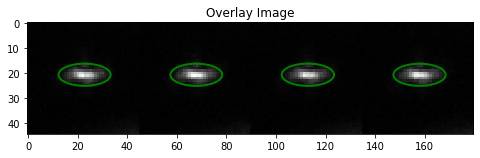

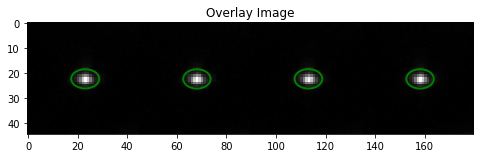

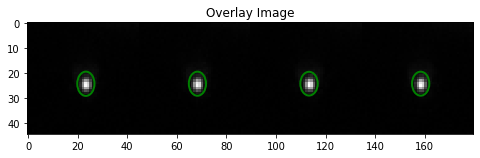

In [8]:
# Overlay image at z near zero.
import storm_analysis.jupyter_examples.overlay_image as overlay_image

overlay_image.overlayImage(tif_file, "calibration.hdf5", 10)
overlay_image.overlayImage(tif_file, "calibration.hdf5", 40)
overlay_image.overlayImage(tif_file, "calibration.hdf5", 70)

Creating an image from the analysis

Tracks not found, using localizations.
.


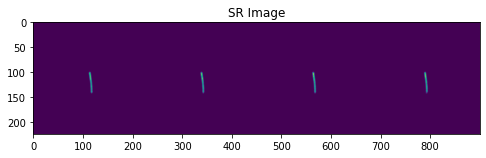

In [9]:
import matplotlib
import matplotlib.pyplot as pyplot
import storm_analysis.sa_utilities.hdf5_to_image as h5_image

#     Create a grayscale image from a HDF5 format localizations file. This will use
#    the tracks if available, otherwise it will use the localizations.


"""
    Create a grayscale image from a HDF5 format localizations file. This will use
    the tracks if available, otherwise it will use the localizations.

    h5_name - The name of the HDF5 file.
    category - Filter for localizations of this category. The default is all categories.
    offsets - List containing [X,Y] offset of the image origin.  The default is no offset.
    scale - The 'zoom' level of the output image, i.e. if the original STORM movie was
            256x256 and scale = 2 then the output image will be 512x512.
    sigma - The sigma to use when rendering gaussians (pixels). If this is None then
            the image will be a histogram.
"""

sr_im = h5_image.render2DImage("calibration.hdf5", scale = 5, sigma = 1) # # This sigma is not same value with above sigma. It has other meaning.

fig = pyplot.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
ax.imshow(sr_im)
ax.set_title("SR Image")

pyplot.show()

### (Optional) Create beads text file for Wobble Correction

In [10]:
def hdf5ToWobbleText(hdf5_name, text_name, x_pix_to_nm, y_pix_to_nm):
    import storm_analysis.sa_library.sa_h5py as saH5Py
    smlc_file_fp = open(text_name, "w")
    smlc_file_fp.write("index, frame, xnano, ynano, znano, intensity\n")

    print("Saving Localizations")
    count = 0
    with saH5Py.SAH5Py(hdf5_name) as h5:
        for fnum, locs in h5.localizationsIterator(fields = ["x", "y", "sum"]):
                 
            for i in range(locs["x"].size):
                count += 1
                xp = locs["x"][i]*x_pix_to_nm
                yp = locs["y"][i]*y_pix_to_nm
                zp = 0.0
                intensity = locs["sum"][i]
                    
                smlc_file_fp.write("{0:d}, {1:d}, {2:.3f}, {3:.3f}, {4:.3f}, {5:.3f}\n".format(count, fnum, xp, yp, zp, intensity))

    print()
    print("Saved", count, "localizations.")
    smlc_file_fp.close()

In [11]:
hdf5ToWobbleText("calibration.hdf5", "wobble.txt", 144.5, 144.5) # x_pix_to_nm, y_pix_to_nm

Saving Localizations

Saved 484 localizations.


### ② Plotting the calibration result

Plot Wx / Wy versus Z curves.

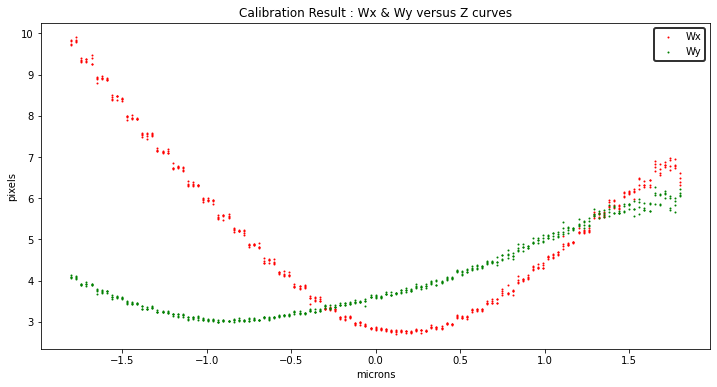

In [12]:
import matplotlib
import matplotlib.pyplot as pyplot

# Change default figure size.
matplotlib.rcParams['figure.figsize'] = (12,6)

import storm_analysis.daostorm_3d.z_calibration as z_cal

[wx, wy, z, pixel_size] = z_cal.loadWxWyZData("calibration.hdf5", address_z_offsets)

p1 = pyplot.scatter(z, wx, color = 'r', label = 'Wx', s=1) # Curves1 (z vs wx)
p2 = pyplot.scatter(z, wy, color = 'g', label = 'Wy', s=1) # Curves2 (z vs wy)
legend = pyplot.legend(handles = [p1, p2], loc=1)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('black')
pyplot.xlabel("microns")
pyplot.ylabel("pixels")
pyplot.title("Calibration Result : Wx & Wy versus Z curves")
pyplot.show()

Fitting (round 1).
[2.6870518615951817, 0.23331069102284693, 0.6072016373310866]
Fitting (round 2).
[2.7413205782897148, 0.18178800638356446, 0.6417688106808308, 0.011213912777632755, 0.02457520126503613, -0.012960672556283144, -0.003844432550098269]
Removing outliers.
Fitting (round 3).


/usr/local/lib/python3.7/dist-packages/storm_analysis-2.2-py3.7.egg/storm_analysis/daostorm_3d/z_calibration.py:396: RuntimeWarning: invalid value encountered in sqrt
  return wo*numpy.sqrt(1.0 + numpy.power(X,2) + A * numpy.power(X,3) + B * numpy.power(X,4) + C * numpy.power(X,5) + D * numpy.power(X,6))


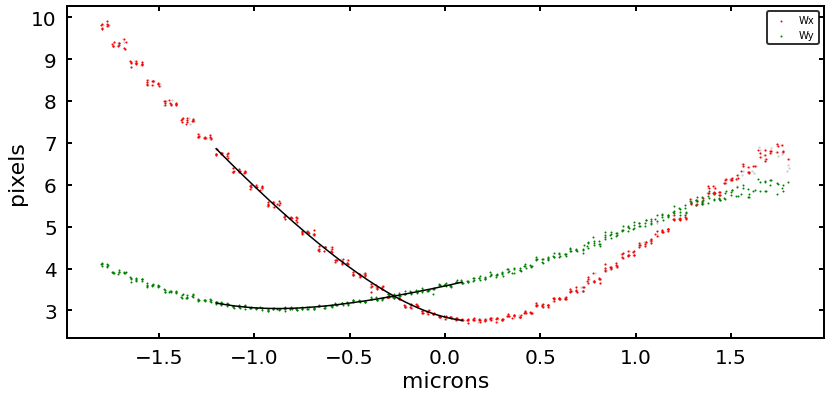

<?xml version="1.0" encoding="ISO-8859-1"?>
<xml>
   <wx_wo>395.968</wx_wo>
   <wx_c>175.113</wx_c>
   <wx_d>638.872</wx_d>
   <wxA>-0.015</wxA>
   <wxB>0.016</wxB>
   <wxC>-0.008</wxC>
   <wxD>-0.002</wxD>
   <wy_wo>440.206</wy_wo>
   <wy_c>-877.648</wy_c>
   <wy_d>1166.152</wy_d>
   <wyA>-0.550</wyA>
   <wyB>0.020</wyB>
   <wyC>0.258</wyC>
   <wyD>-0.087</wyD>
</xml>



In [13]:
###
### The function z_cal.calibrate() will perform all of these steps at once.
###

fit_order = 4
outliers = 3.0 # Sigma to be considered an outlier.

###################################################
#############  Parameter Discription ##############
###################################################

##     wx_params - Parameters for wx versus z fit.
##     wy_params - Parameters for wy versus z fit.
##     z - Numpy array with z values in microns.
##     n_additional - The number of additional fitting parameters to use,
##                    these are 'A,B,C,D'.
##     z_params - (Optional) 3 element list containing an initial guess
##                for the z fitting parameters.
###################################################
###################################################

# Initial guess, this is optional, but might be necessary if your setup is
# significantly different from what storm-analysis expects.

# It can also help to boot-strap to higher fitting orders.

p_start = [3.2,0.19,0.3]
###################################################
###################################################

# Fit curves
print("Fitting (round 1).")
[wx_params, wy_params] = z_cal.fitDefocusingCurves(wx, wy, z, n_additional = 0, z_params = p_start)
print(wx_params)
p_start = wx_params[:3]

# Fit curves.
print("Fitting (round 2).")
[wx_params, wy_params] = z_cal.fitDefocusingCurves(wx, wy, z, n_additional = fit_order, z_params = p_start)
print(wx_params)
p_start = wx_params[:3]

# Remove outliers.
  # This removes all wx, wy that are more than threshold sigma from the fit curve.
print("Removing outliers.")
[t_wx, t_wy, t_z] = z_cal.removeOutliers(wx, wy, z, wx_params, wy_params, outliers)

# Redo fit.
print("Fitting (round 3).")
[wx_params, wy_params] = z_cal.fitDefocusingCurves(t_wx, t_wy, t_z, n_additional = fit_order, z_params = p_start)

# Plot fit.
z_cal.plotFit(wx, wy, z, t_wx, t_wy, t_z, wx_params, wy_params, z_min = min_z, z_max = max_z, z_step = z_step)

# This prints the parameter with the scale expected by 3D-DAOSTORM in the analysis XML file.
z_cal.prettyPrint(wx_params, wy_params, pixel_size = pixel_size)

### ③ Saving New Parameters : 
Create a parameters file with these calibration values.



In [14]:
import storm_analysis.sa_library.parameters as params

# Load the parameters.
new_params = params.ParametersDAO().initFromFile("calibration.xml")

# Update calibration parameters.
z_cal.setWxWyParams(new_params, wx_params, wy_params, pixel_size)

# Do z fitting.
new_params.changeAttr("do_zfit", 1)

# Set maximum allowed distance in wx, wy space that a point can be from the 
# calibration curve.
new_params.changeAttr("cutoff", 2.0)

# Use a higher threshold as the Gaussian PSF is not a good match for our PSF model, so
# we'll get spurious peak splitting if it is too low.
new_params.changeAttr("threshold", 18)

# Don't do tracking or drift correction as this movie is the same as the calibration
# movie, every frame has a different z value.
new_params.changeAttr("radius", 0.0)
new_params.changeAttr("drift_correction", 0)

new_params.prettyPrint()

# Save the changed parameters.
new_params.toXMLFile("measure.xml")

aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 4205.0
convert_to (string) - .txt
cutoff (float) - 2.0
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 1
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 10
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 1
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 0.1
min_z (float) - -1.2
model (string) - 3d
no_fitting (int) - None
parameters_file (parameters_filename) - calibration.xml
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.0
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 18
verbosity (int) - 1
wxA (float) - -0.015221015975182134
wxB (float) - 0.015904017889625234
wxC (float) - -0.007629232004026259
wxD (float) - -0.002081230072591273
wx_c (

## **3) Test : Analyze**

### ① Analyze test movie with the above z-calibration parameters.

In [15]:
if os.path.exists("measure.hdf5"):
    os.remove("measure.hdf5")
    
mfit.analyze(tif_file, "measure.hdf5", "measure.xml")



version 2020.07.01

Peak finding
 Removing values < 1.0 in frame 0
Frame: 0 4 4
 Removing values < 1.0 in frame 1
Frame: 1 4 8
 Removing values < 1.0 in frame 2
Frame: 2 4 12
 Removing values < 1.0 in frame 3
Frame: 3 4 16
 Removing values < 1.0 in frame 4
Frame: 4 4 20
 Removing values < 1.0 in frame 5
Frame: 5 4 24
 Removing values < 1.0 in frame 6
Frame: 6 4 28
 Removing values < 1.0 in frame 7
Frame: 7 4 32
 Removing values < 1.0 in frame 8
Frame: 8 4 36
 Removing values < 1.0 in frame 9
Frame: 9 4 40
 Removing values < 1.0 in frame 10
Frame: 10 4 44
 Removing values < 1.0 in frame 11
Frame: 11 4 48
 Removing values < 1.0 in frame 12
Frame: 12 4 52
 Removing values < 1.0 in frame 13
Frame: 13 4 56
 Removing values < 1.0 in frame 14
Frame: 14 4 60
 Removing values < 1.0 in frame 15
Frame: 15 4 64
 Removing values < 1.0 in frame 16
Frame: 16 4 68
 Removing values < 1.0 in frame 17
Frame: 17 4 72
 Removing values < 1.0 in frame 18
Frame: 18 4 76
 Removing values < 1.0 in frame 19
Fra

### ② Plotting the test result

Plot Wx / Wy versus Z curves for data from the test movie.

Above Calibration curves (Black Line in calibration plotting) was used to calculate Wx / Wy versus Z values.

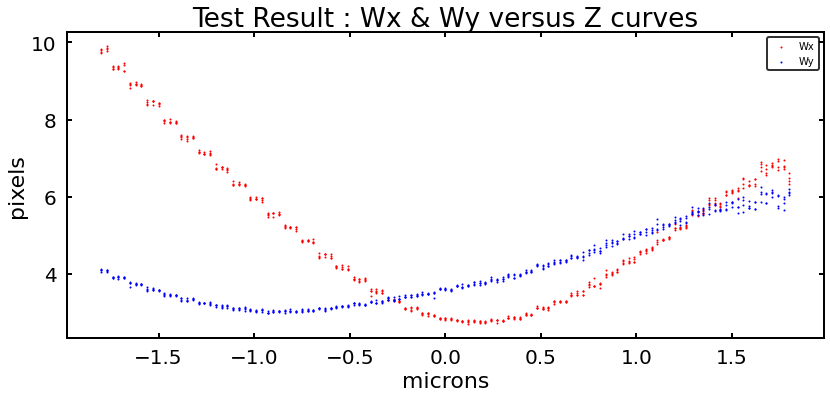

In [16]:
[wx, wy, z, pixel_size] = z_cal.loadWxWyZData("measure.hdf5", address_z_offsets)

p1 = pyplot.scatter(z, wx, color = 'r', label = 'Wx', s=1) # Curves1 (z vs wx)
p2 = pyplot.scatter(z, wy, color = 'b', label = 'Wy', s=1) # Curves2 (z vs wy)
legend = pyplot.legend(handles = [p1, p2], loc=1)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('black')
pyplot.xlabel("microns")
pyplot.ylabel("pixels")
pyplot.title("Test Result : Wx & Wy versus Z curves")
pyplot.show()

## **4) Validation**

### ① Validation Method 1 :

Plot Wx versus Wy with the z calibration curve overlaid.

This can be useful for checking that your calibration curve matches your data.

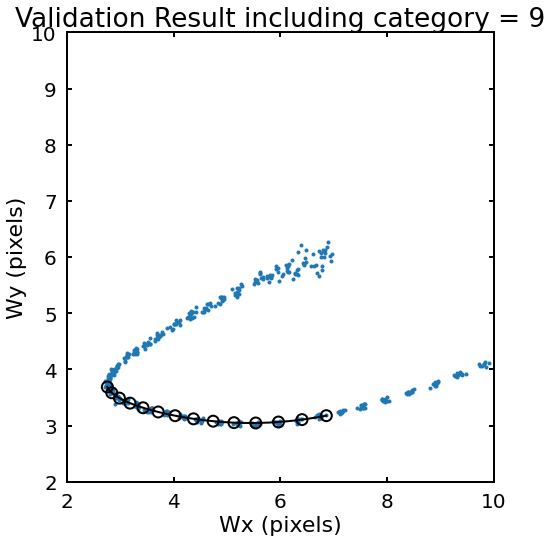

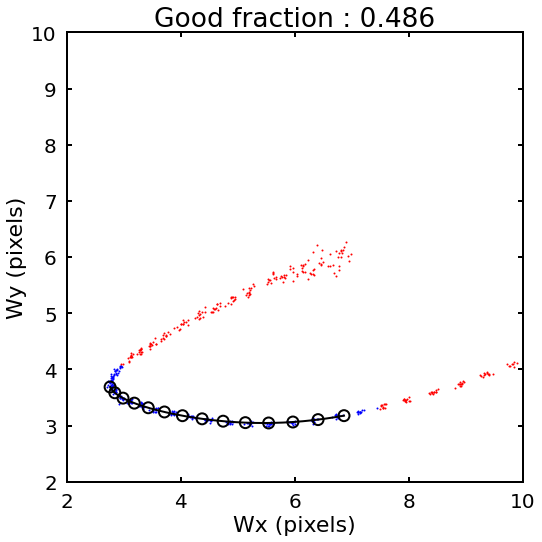

In [17]:
import storm_analysis.sa_library.sa_h5py as saH5Py
import numpy

locs = saH5Py.loadLocalizations("measure.hdf5")
# print('category : ', locs["category"])
# print('total # of category : ', len(locs['category']))

mask = (locs["category"] != 9) # Mark out of z range localizations and tracks as category 9.
wx_good = 2.0*locs["xsigma"][mask]
wy_good = 2.0*locs["ysigma"][mask]

mask = (locs["category"] == 9) # Mark out of z range localizations and tracks as category 9.
wx_bad = 2.0*locs["xsigma"][mask]


wy_bad = 2.0*locs["ysigma"][mask]

# print("Good fraction : {0:.3f}".format(wx_good.size/mask.size))

# Load Z calibration parameters.
m_params = params.ParametersDAO().initFromFile("measure.xml")

[wx_params, wy_params] = m_params.getWidthParams()
[min_z, max_z] = m_params.getZRange()

# Z range is in microns, want nanometers.
min_z = min_z * 1.0e+3
max_z = max_z * 1.0e+3

# Calculate fit z curve at high resolution

fz_wx_1 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size
fz_wy_1 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size

# Calculate fit z curve at 100nm resolution.

fz_wx_2 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size
fz_wy_2 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size

# Make figure.
fig = pyplot.figure(figsize = (8,8))
pyplot.scatter(wx, wy, marker = ".")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.title("Validation Result including category = 9".format(wx_good.size/mask.size))
pyplot.show()

# classified by categories ( Blue -> category != 9, Red -> category = 9)
pyplot.figure(figsize = (8,8))
#pyplot.scatter(wx_good, wy_good, s = 1, color = "blue")
pyplot.scatter(wx_good, wy_good, s = 1, color = "blue")
pyplot.scatter(wx_bad, wy_bad, s = 1, color = "red")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.title("Good fraction : {0:.3f}".format(wx_good.size/mask.size))
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.show()

### ② Validation Method 2 :

Check how well we did at fitting Z.

##################################################
######## Let's Checking how well we did! #########
##################################################

At every 30 frames, we will see the value of measured_z & real_z


frame number =  30
measured_z : [-1.2  -1.2  -1.2  -1.2  -1.2  -1.2  -1.2  -1.2  -1.2  -1.2  -1.2  -1.2
 -1.2  -1.17 -1.17 -1.2  -1.17 -1.18 -1.18 -1.18 -1.17 -1.18 -1.17 -1.16
 -1.17 -1.1  -1.08 -1.08 -1.08 -1.1  -1.08 -1.08 -1.08 -1.08 -1.08 -1.08
 -1.07 -1.   -1.01 -0.99 -1.   -0.99 -1.   -1.   -1.01 -0.99 -1.   -0.98
 -1.   -0.9  -0.9  -0.89 -0.91 -0.91 -0.91 -0.88 -0.91]
real_z :  [-1.35 -1.29 -1.29 -1.29 -1.29 -1.26 -1.26 -1.26 -1.26 -1.23 -1.23 -1.23
 -1.23 -1.2  -1.2  -1.2  -1.2  -1.17 -1.17 -1.17 -1.17 -1.14 -1.14 -1.14
 -1.14 -1.11 -1.11 -1.11 -1.11 -1.08 -1.08 -1.08 -1.08 -1.05 -1.05 -1.05
 -1.05 -1.02 -1.02 -1.02 -1.02 -0.99 -0.99 -0.99 -0.99 -0.96 -0.96 -0.96
 -0.96 -0.93 -0.93 -0.93 -0.93 -0.9  -0.9  -0.9  -0.9 ]

frame number =  60
measured_z : [-1.2  -1

Text(0, 0.5, 'Measured Z (um)')

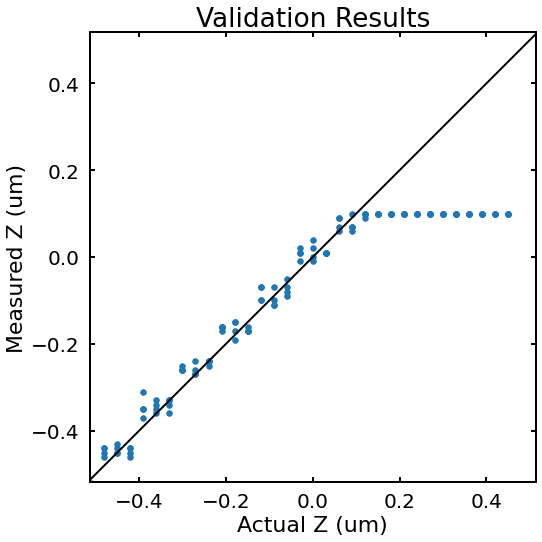

In [18]:
# Create numpy arrays with the real and the measured z values.
measured_z = numpy.array([])
real_z = numpy.array([])
fnum_cnt = 30

print("##################################################")
print("######## Let's Checking how well we did! #########")
print("##################################################\n")
print("At every {} frames, we will see the value of measured_z & real_z\n".format(fnum_cnt))

with saH5Py.SAH5Reader("measure.hdf5") as h5:
    for fnum, locs in h5.localizationsIterator(fields = ["category", "z"]):
        #print("fnum : ", fnum)
        #print("locs : ", locs)
        mask = (locs["category"] != 9)
        z = locs["z"][mask]
        # The z fit function will place all the localizations that are too
        # far from the calibration curve into category 9.
        if z.size != 0:
          measured_z = numpy.concatenate((measured_z, z))
          real_z = numpy.concatenate((real_z, numpy.ones(z.size)*z_offsets[fnum][1]))
          # print('z :',z)
          # print('z.size :', z.size)
          # print("z_offsets :",z_offsets[fnum])
          if fnum%fnum_cnt == 0:
            print("\nframe number = ", fnum)
            print('measured_z :', measured_z)
            print("real_z : ", real_z)
        else:
          continue

# Plot
fig = pyplot.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(real_z, measured_z, s = 30)
ax.plot([-1.0,1.0],[-1.0,1.0], color = 'black', linewidth = 2)
ax.axis("equal")
ax.axis([-0.5, 0.5, -0.5, 0.5])
pyplot.title('Validation Results')
pyplot.xlabel("Actual Z (um)")
pyplot.ylabel("Measured Z (um)")

### ③ Applying CutOff and Analyze again. & Save New_Z txt file.


Change the tolerance for the distance from the calibration curve and redo the Z fit.

In [19]:
import shutil
import storm_analysis.sa_utilities.fitz_c as fitz_c
import storm_analysis.sa_utilities.std_analysis as std_ana

cutoff_params = params.ParametersDAO().initFromFile("measure.xml")

[wx_params, wy_params] = cutoff_params.getWidthParams()
[min_z, max_z] = cutoff_params.getZRange()

# Make a copy of the .hdf5 file as this operation will change it in place.
shutil.copyfile("measure.hdf5", "measure_copy.hdf5")

# If you want to change Cutoff coefficient, use this code line.
  # cutoff_params.changeAttr("cutoff", 0.1) 

print("Previous cutoff coeff is", cutoff_params.getAttr("cutoff"))
cutoff_params.changeAttr("cutoff", 5.0)
print("Curent cutoff coeff is", cutoff_params.getAttr("cutoff"))

# Re-fit z parameters.
fitz_c.fitz("measure_copy.hdf5", cutoff_params.getAttr("cutoff"),
            wx_params, wy_params, min_z, max_z, cutoff_params.getAttr("z_step"))

# Mark out of range peaks as category 9. The range is specified by the min_z and max_z parameters.
std_ana.zCheck("measure_copy.hdf5", cutoff_params)

Previous cutoff coeff is 2.0
Curent cutoff coeff is 5.0
   Processing frame 0
 frame 0


Text(0, 0.5, 'Measured Z (um)')

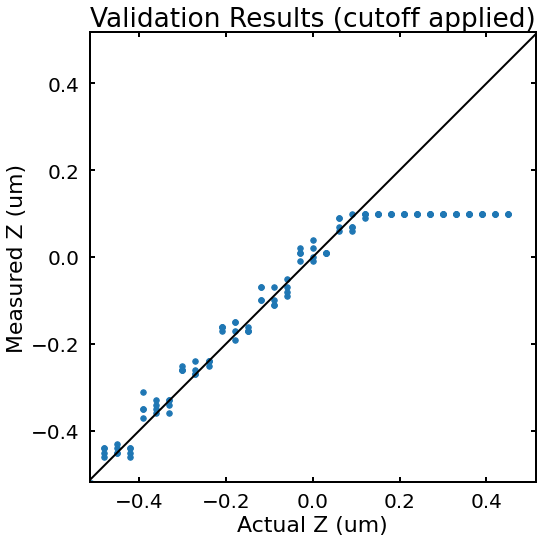

In [20]:
import storm_analysis.sa_library.sa_h5py as saH5Py
import numpy


# Create numpy arrays with the real and the measured z values.
measured_z = numpy.array([])
real_z = numpy.array([])

with saH5Py.SAH5Reader("measure_copy.hdf5") as h5:
    for fnum, locs in h5.localizationsIterator(fields = ["category", "z"]):
        mask = (locs["category"] != 9)
        z = locs["z"][mask]
        # The z fit function will place all the localizations that are too
        # far from the calibration curve into category 9.
        if z.size != 0:
          measured_z = numpy.concatenate((measured_z, z))
          real_z = numpy.concatenate((real_z, numpy.ones(z.size)*z_offsets[fnum][1]))
        else:
          continue
  
# Plot
fig = pyplot.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(real_z, measured_z, s = 30)
ax.plot([-1.0,1.0],[-1.0,1.0], color = 'black', linewidth = 2)
ax.axis("equal")
ax.axis([-0.5, 0.5, -0.5, 0.5])
pyplot.title('Validation Results (cutoff applied)')
pyplot.xlabel("Actual Z (um)")
pyplot.ylabel("Measured Z (um)")

Create [cut-offed] measured_Z txt file.

In [23]:
# Saving [cut-offed] measured_z value as txt file

#float_formatter = "{:.3f}".format
#numpy.set_printoptions(formatter ={'float_kind':float_formatter})

valid = numpy.ones(measured_z.size)
numpy.savetxt("measured_z.txt", numpy.transpose(numpy.vstack((valid, measured_z))), fmt='%.3f')
print("Saving succeeded.")

Saving succeeded.


# SPLINER_MEASURE_PSF

### Prerequisites

A text file containing the z-offset of each frame in the movie. This file contains two columns, the first is whether or not the data in this frame should be used (0 = No, 1 = Yes) and the second contains the z offset in microns.

In [ ]:
# Z offsets profile
address_z_offsets = os.path.join(data_path, "z_offsets.txt")
print("Location of z_offsets : ", address_z_offsets)
z_offsets = numpy.loadtxt(address_z_offsets)
print(z_offsets)

Location of z_offsets :  /content/gdrive/My Drive/data/20210326/z_offsets.txt
[[ 1.   -1.8 ]
 [ 1.   -1.77]
 [ 1.   -1.74]
 [ 1.   -1.71]
 [ 1.   -1.68]
 [ 1.   -1.65]
 [ 1.   -1.62]
 [ 1.   -1.59]
 [ 1.   -1.56]
 [ 1.   -1.53]
 [ 1.   -1.5 ]
 [ 1.   -1.47]
 [ 1.   -1.44]
 [ 1.   -1.41]
 [ 1.   -1.38]
 [ 1.   -1.35]
 [ 1.   -1.32]
 [ 1.   -1.29]
 [ 1.   -1.26]
 [ 1.   -1.23]
 [ 1.   -1.2 ]
 [ 1.   -1.17]
 [ 1.   -1.14]
 [ 1.   -1.11]
 [ 1.   -1.08]
 [ 1.   -1.05]
 [ 1.   -1.02]
 [ 1.   -0.99]
 [ 1.   -0.96]
 [ 1.   -0.93]
 [ 1.   -0.9 ]
 [ 1.   -0.87]
 [ 1.   -0.84]
 [ 1.   -0.81]
 [ 1.   -0.78]
 [ 1.   -0.75]
 [ 1.   -0.72]
 [ 1.   -0.69]
 [ 1.   -0.66]
 [ 1.   -0.63]
 [ 1.   -0.6 ]
 [ 1.   -0.57]
 [ 1.   -0.54]
 [ 1.   -0.51]
 [ 1.   -0.48]
 [ 1.   -0.45]
 [ 1.   -0.42]
 [ 1.   -0.39]
 [ 1.   -0.36]
 [ 1.   -0.33]
 [ 1.   -0.3 ]
 [ 1.   -0.27]
 [ 1.   -0.24]
 [ 1.   -0.21]
 [ 1.   -0.18]
 [ 1.   -0.15]
 [ 1.   -0.12]
 [ 1.   -0.09]
 [ 1.   -0.06]
 [ 1.   -0.03]
 [ 1.    0.  ]
 [ 1.  

A text file containing the approximate bead locations. One way to create this is by using the `visualizer` tool in the `storm_analysis.visualizer` folder. Another alternative might be using ImageJ. Here we are just going to use generated file.

In [ ]:
# Bead Locations
address_bead_locs = os.path.join(data_path, "bead_locs.txt")
print("Location of bead_locs : ", address_bead_locs)

bead_locs = numpy.loadtxt(address_bead_locs)
print(bead_locs)


Location of bead_locs :  /content/gdrive/My Drive/data/20210326/bead_locs.txt
[[ 23.  24.]
 [ 68.  24.]
 [113.  24.]
 [158.  24.]]


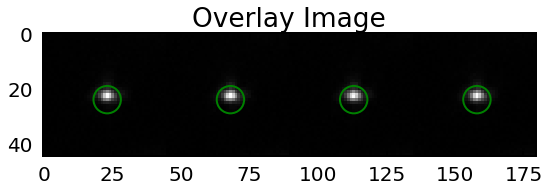

In [ ]:
# Check that the specified positions align with the actual bead locations.
#
import storm_analysis.jupyter_examples.overlay_image as overlay_image
overlay_image.overlayImageBeads(tif_file, address_bead_locs, 40)

### PSF Measurement

Now that we have the 3 files that we need we can measure the PSF. You want to use an AOI that is a bit larger then the size you plan to use when creating the spline file. 

Notes:

* The AOI size is the 1/2 size so using 12 pixels means that the final PSF will be 24 x 24 pixels.
* The pixel size in this simulation was 100nm
* The simulated movie covered a Z range of +-0.6um, so we're using exactly that. For real data you might want to use a Z range that is slightly smaller than range you scanned.
* The Z step size is 50nm, which is fine enough for most applications, assuming a high NA objective with a depth of field on the order of 1um.

Also: 

If you think that your coverslip might not be completely flat, or that your bead locations are not sufficiently accurate then you can set the `refine` parameter to `True`. With this setting each PSF will be aligned to the average of the remaining PSF using a correlation metric. You may see some warning messages like `Warning: Desired error not necessarily achieved due to precision loss.`, it is usually safe to ignore these.

In [ ]:
import storm_analysis.spliner.measure_psf_beads as measure_psf_beads

measure_psf_beads.measurePSFBeads(tif_file, 
                                  address_z_offsets,
                                  address_bead_locs,
                                  "joon-spliner_psf.psf",
                                  aoi_size = 14, # 12 # aoi_size - 1/2 the AOI size in pixels.
                                  pixel_size = 0.1445, #0.1
                                  refine = True,
                                  z_range = 1.5, #0.6
                                  z_step = 0.03) #0.03
                                  

Refining PSF alignment.
0 0 112452.71782214133 [-0.0034196   0.00285976  0.00043804]
0 1 110024.1707318307 [-0.00100371  0.0030761   0.00085964]
0 2 107646.75918014326 [ 0.00647982  0.00236714 -0.00122509]
0 3 105629.64038949035 [-0.0090614  -0.00897914  0.00106695]
Quality score: 1.000192

1 0 98999.51676939694 [-4.80196146e-04  2.01401022e-04  7.34535940e-05]
1 1 99444.47358443936 [-0.00046557  0.00043005  0.00034766]
1 2 99143.50805499 [ 0.00130191  0.00036681 -0.00034024]
1 3 99397.032744735 [-0.00092995 -0.00100019  0.00013759]
Quality score: 1.000210

2 0 98999.69349572038 [-3.77839872e-04  1.54158807e-04  6.18206977e-05]
2 1 99444.64279381395 [-0.00031086  0.00027779  0.00029111]
2 2 99144.56929874767 [ 0.00340895  0.00098695 -0.00107945]
2 3 99397.47145961138 [-0.0006421  -0.00080294  0.00011431]
Quality score: 1.000234

3 0 98999.97864879586 [-2.75253525e-04  1.69316660e-04  5.68833145e-05]
3 1 99444.90123214453 [-0.00012407  0.00034227  0.00036653]
3 2 99144.86588618348 [ 0.0

### Visualizing the measured PSF

Make some images of the measured PSF.

PSF shape: (101, 28, 28)
pixel size: 0.144um
zmin, zmax: -1500.0nm, 1500.0nm


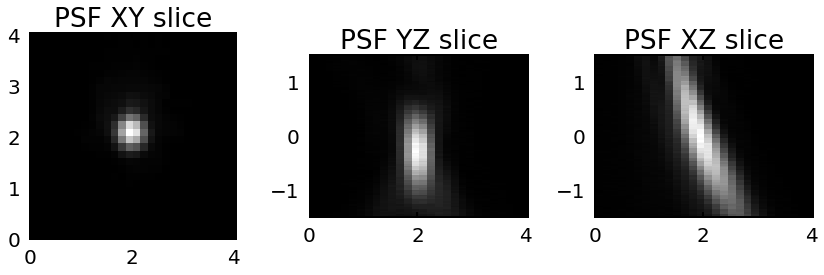

Plots are in microns


In [ ]:
import storm_analysis.jupyter_examples.psf_images as psfImages

psfImages.psfImages("joon-spliner_psf.psf")

Print some properties of the PSF.

In [ ]:
import storm_analysis.spliner.print_psf as printPSF

printPSF.printPSF("joon-spliner_psf.psf")

pixel_size 0.1445
psf shape (101, 28, 28)
type 3D
version 2.0
zmax 1500.0
zmin -1500.0
zvals [-1500.0, -1470.0, -1440.0, -1410.0, -1380.0, -1350.0, -1320.0, -1290.0, -1260.0, -1230.0, -1200.0, -1170.0, -1140.0, -1110.0, -1080.0, -1050.0, -1020.0, -990.0, -960.0, -930.0, -900.0, -870.0, -840.0, -810.0, -780.0, -750.0, -720.0, -690.0, -660.0, -630.0, -600.0, -570.0, -540.0, -510.0, -480.0, -450.0, -420.0, -390.0, -360.0, -330.0, -300.0, -270.0, -240.0, -210.0, -180.0, -150.0, -120.0, -90.0, -60.0, -30.0, 0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0, 360.0, 390.0, 420.0, 450.0, 480.0, 510.0, 540.0, 570.0, 600.0, 630.0, 660.0, 690.0, 720.0, 750.0, 780.0, 810.0, 840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0]


Now you can use `storm_analysis.spliner.psf_to_spline` to convert the PSF into a spline that `Spliner` can use for SMLM movie analysis

In [ ]:
import storm_analysis.spliner.psf_to_spline as psfspline

psfspline.psfToSpline("joon-spliner_psf.psf","spline",10)

Generating 3D spline.
Generating XY splines.
Generating fitting spline.
Calculating spline coefficients.
Calculating spline values.
  0 of 19
  1 of 19
  2 of 19
  3 of 19
  4 of 19
  5 of 19
  6 of 19
  7 of 19
  8 of 19
  9 of 19
  10 of 19
  11 of 19
  12 of 19
  13 of 19
  14 of 19
  15 of 19
  16 of 19
  17 of 19
  18 of 19
  19 of 19
  cx 0.00 19
  cx 0.33 19
  cx 0.67 19
  cx 1.00 19
  cx 1.33 19
  cx 1.67 19
  cx 2.00 19
  cx 2.33 19
  cx 2.67 19
  cx 3.00 19
  cx 3.33 19
  cx 3.67 19
  cx 4.00 19
  cx 4.33 19
  cx 4.67 19
  cx 5.00 19
  cx 5.33 19
  cx 5.67 19
  cx 6.00 19
  cx 6.33 19
  cx 6.67 19
  cx 7.00 19
  cx 7.33 19
  cx 7.67 19
  cx 8.00 19
  cx 8.33 19
  cx 8.67 19
  cx 9.00 19
  cx 9.33 19
  cx 9.67 19
  cx 10.00 19
  cx 10.33 19
  cx 10.67 19
  cx 11.00 19
  cx 11.33 19
  cx 11.67 19
  cx 12.00 19
  cx 12.33 19
  cx 12.67 19
  cx 13.00 19
  cx 13.33 19
  cx 13.67 19
  cx 14.00 19
  cx 14.33 19
  cx 14.67 19
  cx 15.00 19
  cx 15.33 19
  cx 15.67 19
  cx 16.00 19
  

Reference printPSF.printPSF() results:

pixel_size 0.1
psf shape (25, 24, 24)
type 3D
version 2.0
zmax 600.0
zmin -600.0
zvals [-600.0, -550.0, -500.0, -450.0, -400.0, -350.0, -300.0, -250.0, -200.0, -150.0, -100.0, -50.0, 0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0]